### Sections:
1. [Section 1 - Strategy](#my-bookmark1) <br>
2. [Section 2 - Backtesting](#my-bookmark2)<br>

## Section 1 - Strategy

<a id="my-bookmark1"></a>


### Import packages

In [1]:
# Load libraries.

import numpy as np
import pandas as pd
import pandas_ta as pta

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# for assessment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns

import time

import datetime as dt
import re

import plotly.express as px

from pandas_datareader import data as pdr

import yfinance as yf

(
    yf
    .pdr_override()
)

import warnings
warnings.filterwarnings("ignore")

# Setting baseline seed
np.random.seed(230218)

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline


### Data Preparation

In [2]:
import pandas_datareader.data as web
from pandas_datareader import data as pdr

import time

import datetime as dt
import yfinance as yf

(
    yf
    .pdr_override()
)
stock_ticker = ["SPY"]
start = dt.datetime(2004, 11, 1)
end = dt.datetime(2023, 11, 1)

stock_data_raw = pdr.get_data_yahoo(stock_ticker, start = start, end = end).dropna()


[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data_raw.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-01,113.559998,113.839996,113.199997,113.510002,78.617943,36720900
2004-11-02,113.669998,114.570000,113.220001,113.550003,78.645615,56210000


In [4]:
stock_data_raw["log_returns"] = np.log(stock_data_raw["Adj Close"] / stock_data_raw["Adj Close"].shift(1))

### Benchmark : S&P500

In [5]:
stock_data_raw['cumulative_holding_returns'] = stock_data_raw['log_returns'].cumsum().apply(np.exp)


<Axes: xlabel='Date'>

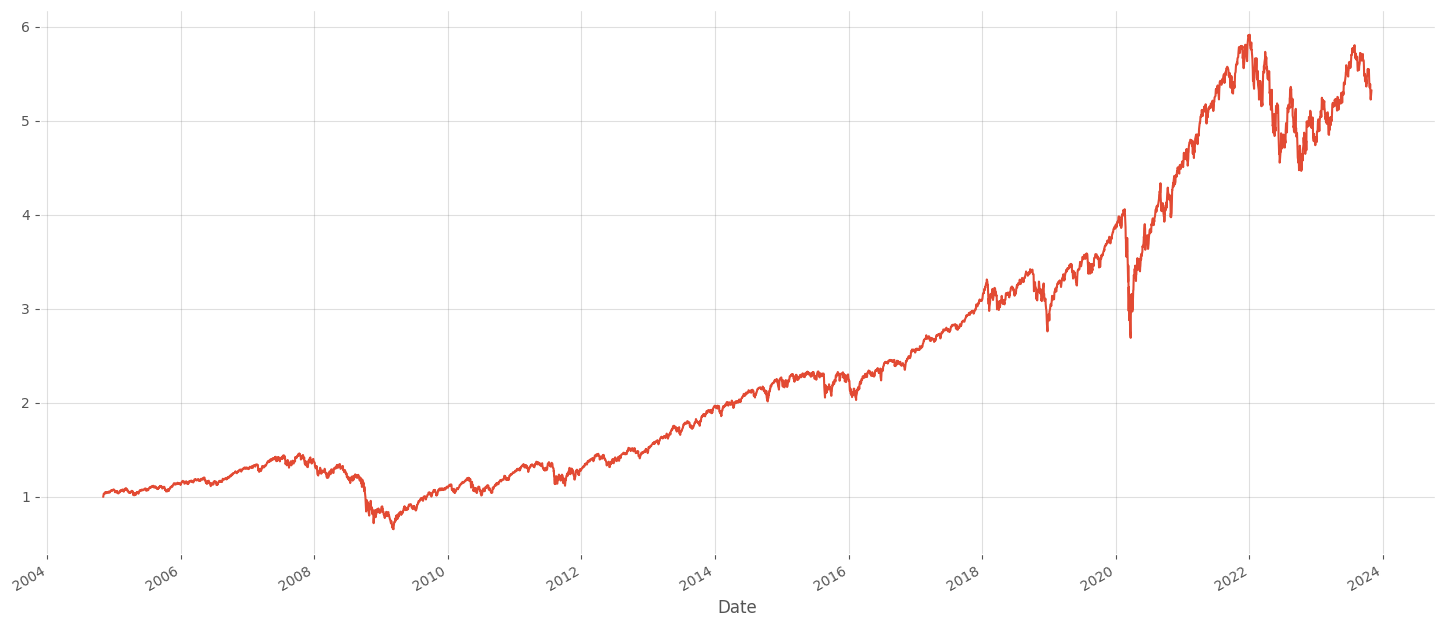

In [6]:
stock_data_raw["cumulative_holding_returns"].plot(figsize = [18, 8])


In [7]:
spy_cumulative_return = stock_data_raw['cumulative_holding_returns'][-1]


In [8]:
print("SPY cumulative return is: "+ str(spy_cumulative_return))


SPY cumulative return is: 5.319396530349367


### Strategy 1: Mean Reversion Strategy

Mean reversion strategy that is employed here is distance measure with variable threshold. The threshold being used is the rolling moving standard deviation. There are several user defined hyperparameters that we can input, and hence, i will use a simple optimization process in which it will iterate and find the combination of parameters that yields the highest cumulative returns. 

#### optimizing the best parameters to be used for variable distance mean reversion strategy


In [9]:
param1_values = [10,20,25,30,35,40,45,50,55,60,70]
param2_values = [2,2.5,3,3.5,4]
param3_values = [10,20,35,30,35,40,45,50,55,60,70]

columns = ['returns','mean rolling window','threshold','std rolling window']
desired_size = len(param1_values)*len(param2_values)*len(param3_values)
results_df = pd.DataFrame(index=range(desired_size), columns=columns)

stock_data = pd.DataFrame(index = stock_data_raw.index)
# Perform parameter tuning using nested loops
i = 0
for param1 in param1_values:
    for param2 in param2_values:
        for param3 in param3_values:
            stock_data["log_returns"] = np.log(stock_data_raw["Adj Close"] / stock_data_raw["Adj Close"].shift(1))

            stock_data["SMA_42"] = stock_data_raw["Adj Close"].rolling(window = param1).mean()

            num_of_std = param2
            stock_data['upper_threshold'] = num_of_std * (stock_data_raw["Adj Close"].rolling(window = param3).std())
            stock_data['lower_threshold'] = -num_of_std * (stock_data_raw["Adj Close"].rolling(window = param3).std())

            stock_data["distance"] = stock_data_raw["Adj Close"] - stock_data["SMA_42"]

            # trading position logic
            stock_data["positions"] =\
            (
                np
                .where(stock_data["distance"] > stock_data['upper_threshold'], # overbought --> sell (short)
                       -1, np.nan)
            )

            stock_data["positions"] =\
            (
                np
                .where(stock_data["distance"] < -stock_data['lower_threshold'], # oversold --> buy (long)
                       1, stock_data["positions"]
                      )
            )

            stock_data["positions"] =\
            (
                np
                #           +                            - 
                #           -                            +
                .where(stock_data["distance"] * stock_data["distance"].shift(1) < 0, # exit pos when sign changes
                       0, stock_data["positions"]
                      )
            )
            stock_data["positions"] = stock_data["positions"].ffill() # replace null values with the values from previous row
            ## because we want the position to stay constant unless it met the next condition
            stock_data["positions"] = stock_data["positions"].fillna(0)

            # still in log
            stock_data["strategy_returns"] = stock_data["positions"].shift(1) * stock_data["log_returns"]

            stock_data['log_returns'][0]=0
            stock_data['strategy_returns'][0]=0

            # cumulative returns
            stock_data['log_returns'] = stock_data['log_returns']
            cumulative_returns = stock_data['strategy_returns'].cumsum().apply(np.exp)
            stock_data['cumulative_returns'] = stock_data['strategy_returns'].cumsum().apply(np.exp)
            stock_data['cumulative_holding_returns'] = stock_data['log_returns'].cumsum().apply(np.exp)
            
            # store data
            results_df.iloc[i,0] = cumulative_returns[-1]
            results_df.iloc[i,1] = param1
            results_df.iloc[i,2] = param2
            results_df.iloc[i,3] = param3
            
            i=i+1
          

In [10]:
results_df.sort_values(by='returns', ascending = False)

,returns,mean rolling window,threshold,std rolling window
122,6.1971,25,2.5,20
112,5.869504,25,2,35
114,5.869504,25,2,35
117,5.667667,25,2,50
116,5.627672,25,2,45
...,...,...,...,...
506,2.013493,60,2.5,10
561,1.834374,70,2.5,10
341,1.775178,45,2.5,10
231,1.584563,35,2.5,10


Based on the optimization exercise above are, the best hyperparameter combinations are:

- number of standard deviation as the threshold: 2.5
- mean rolling windows: 25 days
- standard deviation rolling windows: 20 days

#### Running the variable distance mean reversion strategy using the best parameters obtained from the optimization


In [11]:
stock_data["SMA"] = stock_data_raw["Adj Close"].rolling(window = 25).mean()

num_of_std = 2.5
stock_data['upper_threshold'] = num_of_std * (stock_data_raw["Adj Close"].rolling(window = 20).std())
stock_data['lower_threshold'] = -num_of_std * (stock_data_raw["Adj Close"].rolling(window = 20).std())

stock_data["distance"] = stock_data_raw["Adj Close"] - stock_data["SMA"]

# trading position logic
stock_data["positions"] =\
(
    np
    .where(stock_data["distance"] > stock_data['upper_threshold'], # overbought --> sell (short)
           -1, np.nan)
)

stock_data["positions"] =\
(
    np
    .where(stock_data["distance"] < -stock_data['lower_threshold'], # oversold --> buy (long)
           1, stock_data["positions"]
          )
)

stock_data["positions"] =\
(
    np
    #           +                            - 
    #           -                            +
    .where(stock_data["distance"] * stock_data["distance"].shift(1) < 0, # exit pos when sign changes
           0, stock_data["positions"]
          )
)
stock_data["positions"] = stock_data["positions"].ffill() # replace null values with the values from previous row
## because we want the position to stay constant unless it met the next condition
stock_data["positions"] = stock_data["positions"].fillna(0)

# still in log
stock_data["strategy_returns"] = stock_data["positions"].shift(1) * stock_data["log_returns"]

stock_data['log_returns'][0]=0
stock_data['strategy_returns'][0]=0

# cumulative returns
stock_data['cumulative_returns'] = stock_data['strategy_returns'].cumsum().apply(np.exp)


Text(0.5, 1.0, 'Distance vs Variable Threshold')

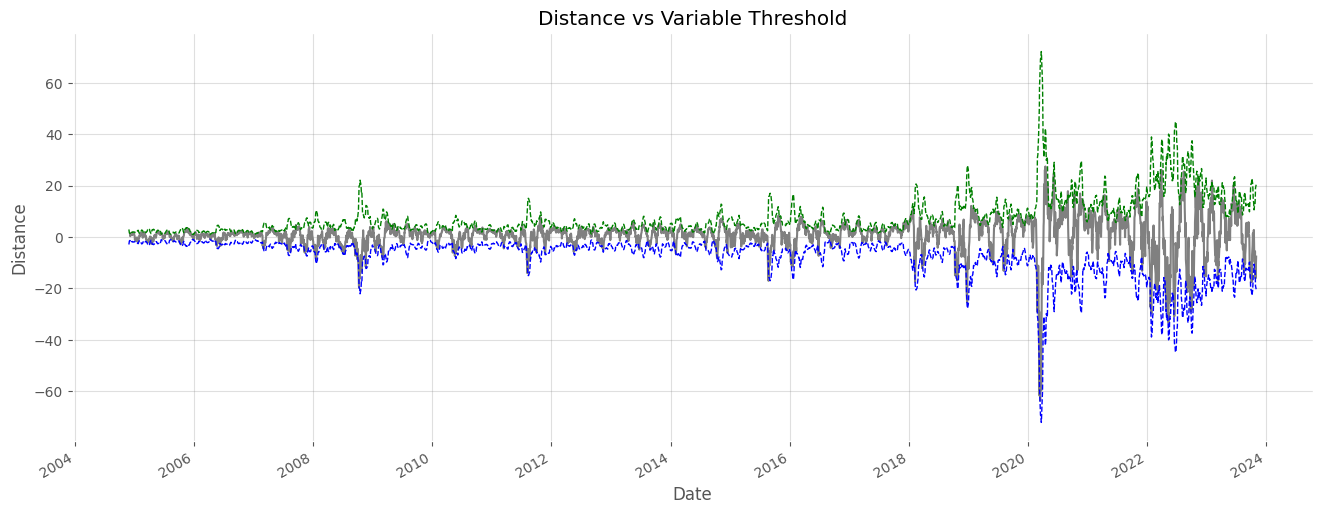

In [12]:
fig, ax = plt.subplots(figsize=[16, 6])
stock_data["distance"].dropna().plot(figsize = [16, 6], color = 'grey')
stock_data['upper_threshold'].plot(color = 'green',style = '--',ax = ax,label = 'Boundary',lw=1)
stock_data['lower_threshold'].plot(color = 'blue',style = '--',ax = ax,label = 'Boundary',lw=1)
plt.ylabel('Distance')
plt.title('Distance vs Variable Threshold')

Text(0.5, 1.0, 'Stock Price vs Threshold (adjusted with stock price scale)')

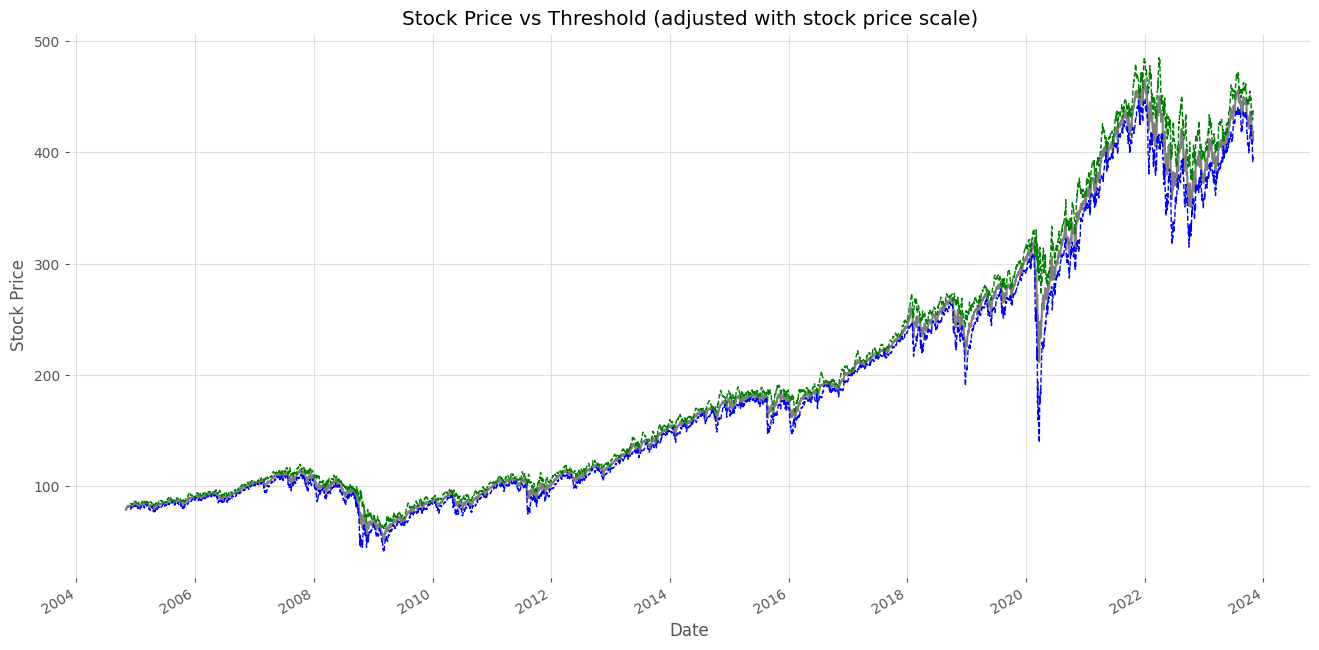

In [13]:
fig, ax = plt.subplots(1,figsize = (16,8))
plot_upper_threshold = (stock_data['upper_threshold']+stock_data_raw["Adj Close"])
plot_lower_threshold = (stock_data['lower_threshold']+stock_data_raw["Adj Close"])

stock_data_raw["Adj Close"].plot(color = 'grey',ax = ax,label = 'Close price')
plot_upper_threshold.plot(color = 'green',style = '--',ax = ax,label = 'Boundary',lw=1)
plot_lower_threshold.plot(color = 'blue',style = '--',ax = ax,label = 'Boundary',lw=1)

plt.ylabel('Stock Price')
plt.title('Stock Price vs Threshold (adjusted with stock price scale)')

Mean Reversion Strategy Returns: 519.7100199824524 %
S&P500 Holding returns: 431.9396530349367 %


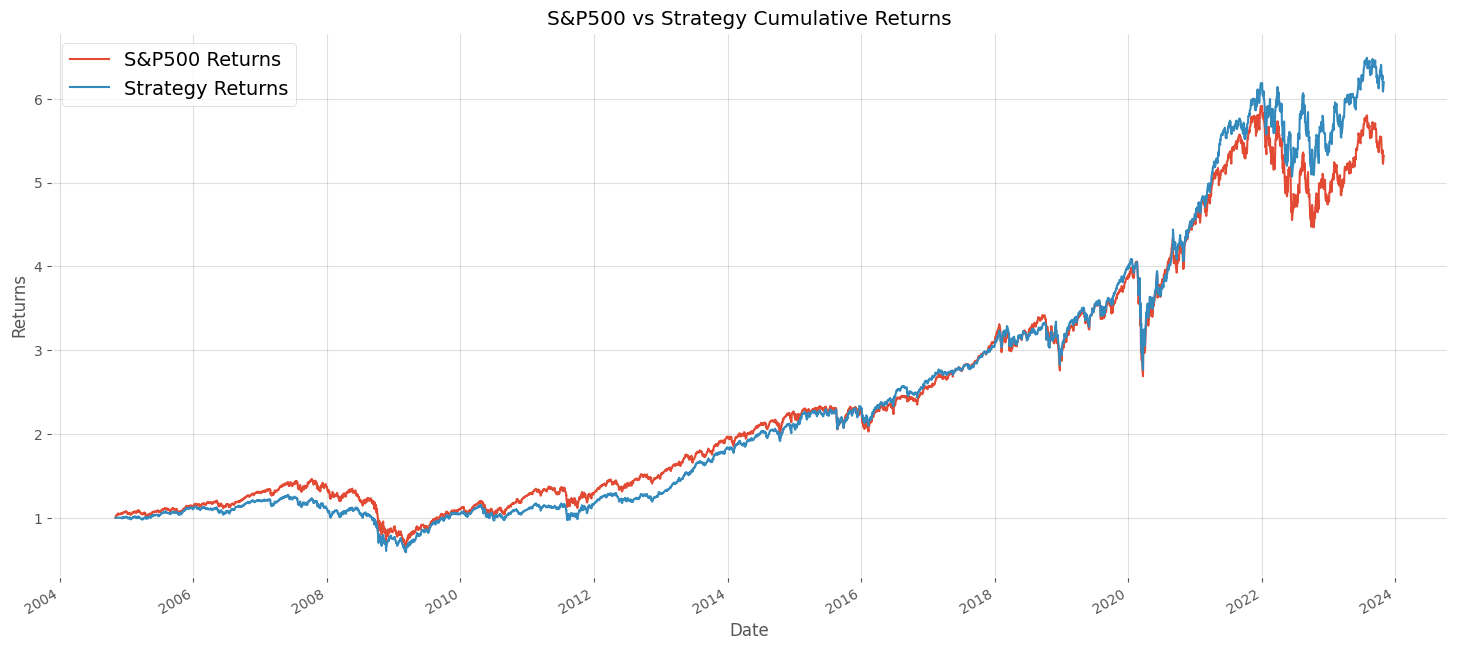

In [14]:
ax = stock_data[["log_returns", "strategy_returns"]].cumsum().apply(np.exp).plot(figsize=[18, 8])
ax.legend(["S&P500 Returns", "Strategy Returns"])
print("Mean Reversion Strategy Returns:" ,((stock_data['cumulative_returns'][-1])-1)*100,"%")
print("S&P500 Holding returns:", ((stock_data['cumulative_holding_returns'][-1])-1)*100,"%")

plt.ylabel('Returns')
plt.title('S&P500 vs Strategy Cumulative Returns')
plt.show()


### Strategy 2: Momentum Strategy

In [15]:
snp = stock_data_raw

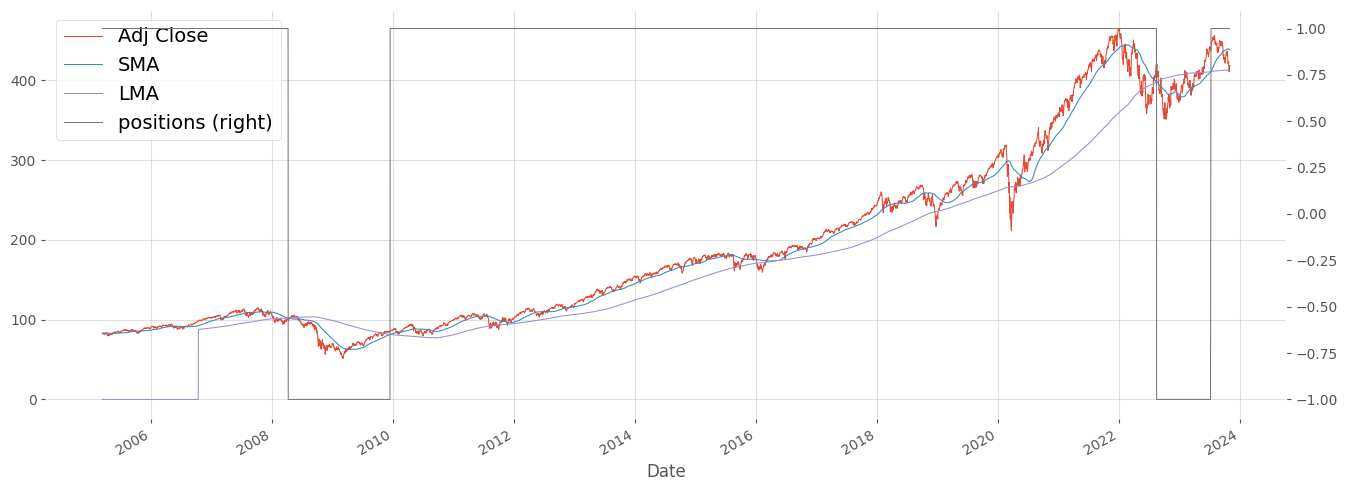

In [16]:
snp["SMA"] = snp["Adj Close"].rolling(window = 95).mean()

#snp short moving average using 95 days after much trial and error. 

snp["LMA"] = snp["Adj Close"].rolling(window = 495).mean()
#snp long moving average using 495 days after much trial and error.

snp = snp.fillna(0)
snp["positions"] = np.where(snp["SMA"] > snp["LMA"], 1, -1)
snp["positions"] = np.where(snp["SMA"] ==0,0,snp["positions"])

#display periods we are long and periods we are short


first_buy = snp["positions"][snp["positions"] == 1].index[0]
first_buy

#when we have our first buy in date. 

snp[["Adj Close", "SMA", "LMA", "positions"]].loc[first_buy:].dropna().plot(figsize = [16,6], lw = 0.75, secondary_y="positions")
plt.show()

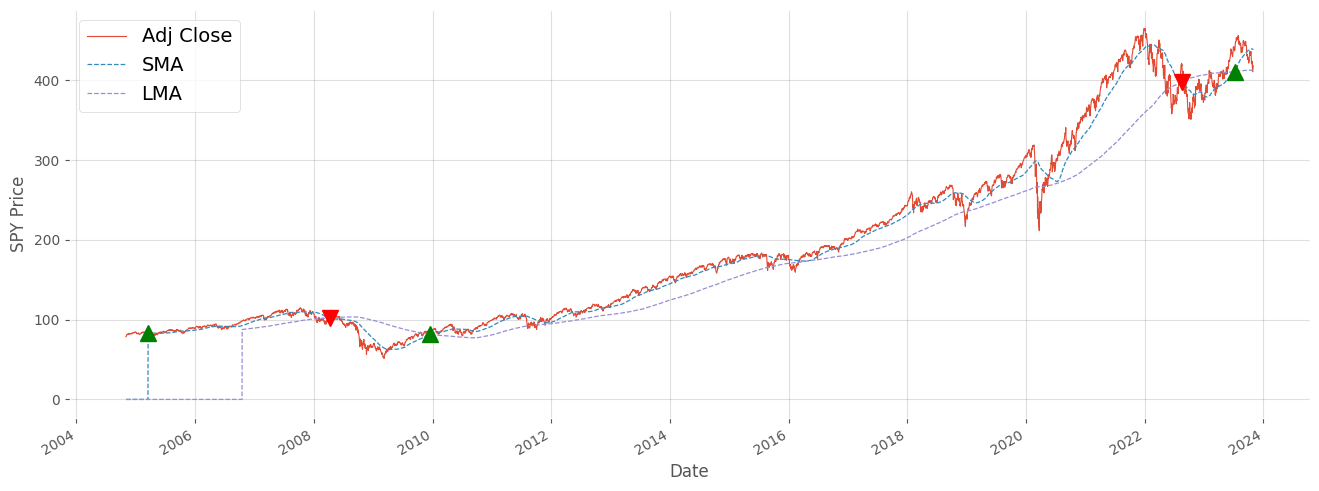

In [17]:
snp["Buy_Sell"] = np.where(snp["SMA"] > snp["LMA"], 1, 0)
snp["Trading_Positions"] = snp["Buy_Sell"].diff()
snp["Trading_Positions"].value_counts()

# it is as good as a passive strategy with this total number of buy and sell over 20 years.

fig = plt.figure(figsize = [16,6])
sub = fig.add_subplot(111, ylabel = "SPY Price")
snp[["Adj Close"]].plot(ax = sub, lw = 0.8)
snp[["SMA", "LMA"]].plot(ax = sub, lw = 0.9, style = "--")
sub.plot(snp[snp["Trading_Positions"] == 1].index, snp.SMA[snp["Trading_Positions"] == 1], "^", color = "green", markersize = 12)
sub.plot(snp[snp["Trading_Positions"] == -1].index, snp.SMA[snp["Trading_Positions"] == -1], "v", color = "red", markersize = 12)
plt.show()

# nicer plot show where we long and short our sp500.

Momentum Strategy Returns: 532.5937882735442 %
S&P500 Holding returns: 431.9396530349367 %


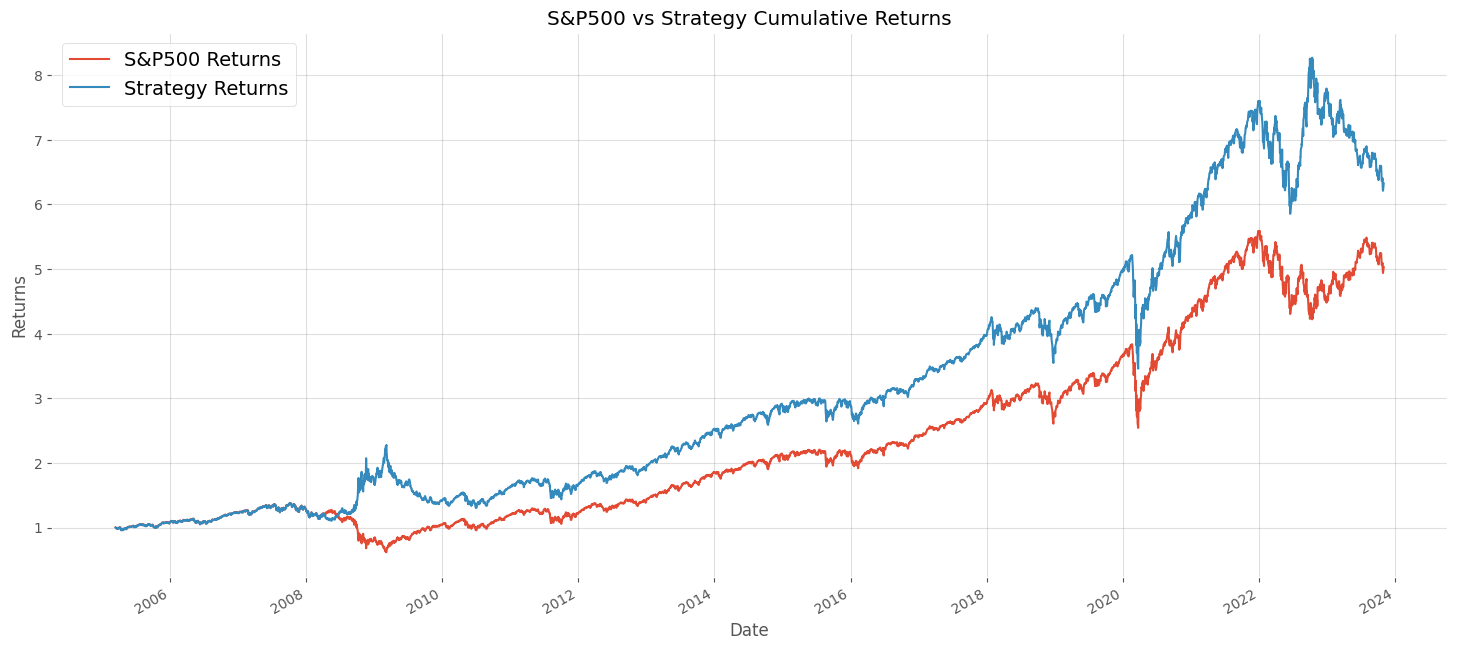

In [18]:
snp["Strategy"] = snp["positions"].shift(1) * snp["log_returns"]
ax = snp[["log_returns", "Strategy"]].loc[first_buy:].dropna().cumsum().apply(np.exp).plot(figsize=[18, 8])
ax.legend(["S&P500 Returns", "Strategy Returns"])
print("Momentum Strategy Returns:" ,((snp["Strategy"].loc[first_buy:].dropna().cumsum().apply(np.exp)[-1])-1)*100,"%")
print("S&P500 Holding returns:", ((stock_data['cumulative_holding_returns'][-1])-1)*100,"%")

plt.ylabel('Returns')
plt.title('S&P500 vs Strategy Cumulative Returns')
plt.show()


### Stretegy 3: Machine Learning Strategy

In [19]:
currency_ticker = ["DEXJPUS", "DEXUSUK"]
index_ticker = ["VIXCLS"]

return_period = 5

spy_data = stock_data_raw
currency_data = web.get_data_fred(currency_ticker, start, end)
index_data = web.get_data_fred(index_ticker, start, end)


In [20]:
"""
Adding input features to the dataframe. We'll be using the following:
1. SPY Volume
2. Weekly log returns of JPY USD Xccy
3. Weekly log returns of USD GBP Xccy
4. Weekly log returns of VIX 
5. 5 day lagged returns of SPY
5. 15 day lagged returns of SPY
5. 30 day lagged returns of SPY
5. 60 day lagged returns of SPY
6. RSI
7. MACD
8. 15 day SMA
9. 60 day SMA
"""

X = pd.DataFrame()

X['SPYVolume'] = spy_data['Volume']

X['DEXJPUS'] = np.log(currency_data['DEXJPUS']).diff(return_period)
X['DEXUSUK'] = np.log(currency_data['DEXUSUK']).diff(return_period)

X['VIXCLS'] = np.log(index_data['VIXCLS']).diff(return_period)

X['5dret'] = np.log(spy_data["Adj Close"]).diff(return_period)
X['15dret'] = np.log(spy_data["Adj Close"]).diff(return_period * 3)
X['30ret'] = np.log(spy_data["Adj Close"]).diff(return_period * 6)
X['60dret'] = np.log(spy_data["Adj Close"]).diff(return_period * 12)

# X['15SMA'] = stock_data['Adj Close'].rolling(15).mean()
# X['60SMA'] = stock_data['Adj Close'].rolling(60).mean()
# X['RSI'] = pta.rsi(spy_data["Adj Close"])
# X['MACD'] = pta.macd(spy_data["Adj Close"])['MACD_12_26_9']
            
X

,SPYVolume,DEXJPUS,DEXUSUK,VIXCLS,5dret,15dret,30ret,60dret
Date,,,,,,,,
2004-11-01,36720900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-02,56210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-03,76960200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-04,55350300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-11-05,63287200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-10-25,94223200,0.000534,-0.000823,0.049236,-0.029869,-0.016885,-0.063536,-0.085620
2023-10-26,115156800,0.003463,-0.002638,-0.034224,-0.033091,-0.028555,-0.084169,-0.083658
2023-10-27,107367700,-0.001670,-0.000165,-0.020475,-0.025270,-0.044901,-0.076590,-0.085331


In [21]:
"""
We will be predicting log weekly returns
"""

Y = pd.DataFrame()

Y['label'] = np.log(spy_data['Adj Close']).diff(return_period).shift(-return_period)

Y

,label
Date,
2004-11-01,0.031223
2004-11-02,0.028905
2004-11-03,0.017159
2004-11-04,0.011177
2004-11-05,0.012793
...,...
2023-10-25,NaN
2023-10-26,NaN
2023-10-27,NaN


In [22]:
"""
Concatenate features and labels into model_data.
Apply MinMax Scaling
Drop all Nan Values
Only use Weekly values
"""
model_data = pd.concat([X, Y], axis=1)
scaler = MinMaxScaler()
model_data[model_data.columns[:-1]] = scaler.fit_transform(model_data[model_data.columns[:-1]])
model_data = model_data.dropna().iloc[ : :return_period, :]


model_data

,SPYVolume,DEXJPUS,DEXUSUK,VIXCLS,5dret,15dret,30ret,60dret,label
Date,,,,,,,,,
2005-01-27,0.047454,0.556944,0.637626,0.303265,0.552819,0.575151,0.574865,0.659958,0.012945
2005-02-03,0.039225,0.651215,0.578647,0.260676,0.586849,0.589319,0.592836,0.638770,0.006536
2005-02-10,0.035745,0.634681,0.568290,0.314774,0.570741,0.616239,0.590519,0.626990,0.004083
2005-02-17,0.050077,0.549432,0.664866,0.342055,0.564579,0.624313,0.640431,0.639069,0.009932
2005-02-25,0.053321,0.538116,0.652256,0.345004,0.579276,0.619113,0.648518,0.651467,0.010649
...,...,...,...,...,...,...,...,...,...
2023-09-22,0.099981,0.584035,0.537308,0.458907,0.479818,0.511625,0.561893,0.599822,-0.006854
2023-09-29,0.116632,0.616810,0.577170,0.339758,0.537091,0.518405,0.585166,0.583223,0.004807
2023-10-06,0.114440,0.551958,0.613956,0.326558,0.566398,0.528972,0.590508,0.562983,0.004553


In [23]:
"""
Split train and test sets
"""

validation_size = 0.20

train_size = int(len(model_data)*(1 - validation_size))

X_train, X_test = model_data.iloc[:train_size,:len(model_data.columns) - 1], model_data.iloc[train_size:len(model_data),:len(model_data.columns) - 1]

Y_train, Y_test = model_data.iloc[:train_size, len(model_data.columns) - 1], model_data.iloc[train_size:len(model_data), len(model_data.columns) - 1]

In [24]:
"""
Prepare for K-means cross validation over multiple models
"""

num_folds = 10
seed = 132948
scoring = "neg_mean_squared_error"

models = []

models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso(alpha=0.1)
             )
            )

models.append(("EN", ElasticNet(alpha=0.1)
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()
              )
             )

# Boosting

models.append(("GBR", GradientBoostingRegressor()
              )
             )

models.append(("ABR", AdaBoostRegressor()
              )
             )

In [25]:
names = []

kfold_results = []

train_results = []
test_results = []

preds = pd.DataFrame()

for name, model in models:
    
    names.append(name)
        
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
        
    kfold_results.append(cv_results)
  
    res = model.fit(X_train, Y_train)

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)
    

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

print("Model with lowest training error is {}".format(names[np.argmin(test_results)]))



LR: 0.000646 (0.000314) 0.000580 0.000905
LASSO: 0.000600 (0.000275) 0.000596 0.000908
EN: 0.000600 (0.000275) 0.000596 0.000908
CART: 0.001485 (0.000919) 0.000000 0.002255
KNN: 0.000744 (0.000358) 0.000486 0.000930
SVR: 0.000930 (0.000378) 0.000777 0.001110
RFR: 0.000717 (0.000342) 0.000099 0.000955
ETR: 0.000668 (0.000315) 0.000000 0.000940
GBR: 0.000721 (0.000371) 0.000201 0.001098
ABR: 0.000626 (0.000284) 0.000385 0.001016
Model with lowest training error is LR


In [26]:
model_data[names[np.argmin(test_results)] + '_preds'] = res.predict(model_data[['SPYVolume', 'DEXJPUS', 'DEXUSUK', 'VIXCLS', '5dret', '15dret', '30ret', '60dret']])
spy_data = spy_data.join(model_data[names[np.argmin(test_results)] + '_preds'], on='Date')
spy_data['positions'] = np.where(spy_data[names[np.argmin(test_results)] + '_preds'] > 0, 1, 0)

## Section 2 - Backtesting

<a id="my-bookmark2"></a>


## 1. Backtesting (Visualization + Money Remaining)

In [27]:
def Backtesting(stock_data, number_of_stocks):
    # set initial parameters
    Capital = 100000
    number_of_stocks = number_of_stocks
    commission = 0
    
    Portfolio = pd.DataFrame(index = stock_data.index).fillna(0.0)
    
    # get the trading order
    stock_data["BUY_or_SELL"] = np.sign(stock_data["positions"].diff())

    Portfolio["number of stock holdings"] = stock_data["positions"]* number_of_stocks
    Portfolio["difference in shares owned"] = Portfolio["number of stock holdings"].diff()
    Portfolio["holdings market value"] = Portfolio["number of stock holdings"]* stock_data_raw["Adj Close"]
    Portfolio["our_holdings"] = Portfolio["number of stock holdings"].multiply(stock_data_raw["Adj Close"],axis = 0) # applicable in the case when we have multiple holdings (not only META)
    Portfolio["commission"] = ((stock_data["positions"].diff())* commission).cumsum()
    Portfolio["our_cash"] = Capital - (Portfolio["difference in shares owned"].multiply(stock_data_raw["Adj Close"], axis = 0)).cumsum()

    Portfolio["total"] = Portfolio["our_cash"] + Portfolio["our_holdings"] - Portfolio["commission"]
    Portfolio["holding_value"] = stock_data_raw["Adj Close"] * number_of_stocks + (Capital - stock_data_raw["Adj Close"][0]*number_of_stocks)

    # cumulative returns
    Portfolio["cash_log_returns"] = np.log(Portfolio["total"]/Portfolio['total'].shift(1))
    Portfolio['cash_cumulative_returns']=Portfolio['cash_log_returns'].cumsum().apply(np.exp)
    cumul = (Portfolio['cash_cumulative_returns'][-1]-1)*100
    
    Portfolio["holding_log_returns"] = np.log(Portfolio["holding_value"]/Portfolio['holding_value'].shift(1))
    Portfolio['holding_cumulative_returns']=Portfolio['holding_log_returns'].cumsum().apply(np.exp)
    cumul_holdings = (Portfolio['holding_cumulative_returns'][-1]-1)*100

    # print result
    print("Strategy ending balance is: " + str(Portfolio["total"][-1]))
    print("S&P500 holding ending balance is: " + str(Portfolio["holding_value"][-1]))

    print("Strategy cumulative return is: " + str(cumul)+ '%')
    print("S&P500 holding cumulative return is: " + str(cumul_holdings)+ '%')
    
    # plot 2
    fig = plt.figure(figsize = [16, 10])
    sub = fig.add_subplot(111,ylabel = "Value of Our Portfolio (USD)")
    Portfolio[["total","holding_value"]].plot(ax = sub,lw = 0.80)

    # Buy
    (
        sub
        .plot(Portfolio.loc[stock_data["BUY_or_SELL"] == 1.0].index,
              Portfolio.total[stock_data["BUY_or_SELL"] == 1.0],
              "^",
              color = "green",
              markersize = 2
             )
    )

    # Sell
    (
        sub
        .plot(Portfolio.loc[stock_data["BUY_or_SELL"] == -1.0].index,
              Portfolio.total[stock_data["BUY_or_SELL"] == -1.0],
              "v",
              color = "red",
              markersize = 2
             )
    )

    plt.show()
    
    return Portfolio

### Strategy 1 Backtesting

Strategy ending balance is: 484252.6039123535
S&P500 holding ending balance is: 422602.965927124
Strategy cumulative return is: 384.25260391235787%
S&P500 holding cumulative return is: 322.6029659271248%


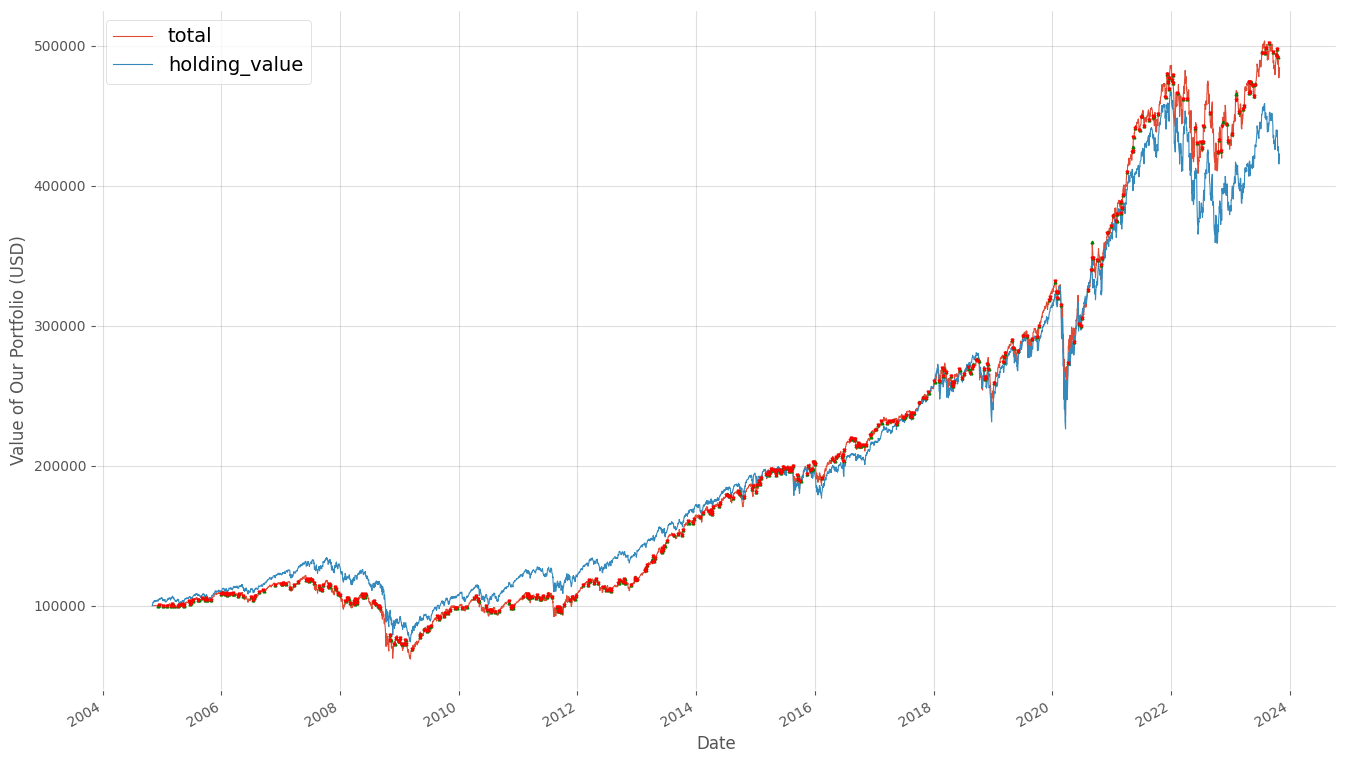

In [28]:
strategy_1_backtesting = Backtesting(stock_data,950)


In [29]:
strategy_1_backtesting.to_excel("strat1.xlsx")

In [30]:
strategy_1_backtesting[strategy_1_backtesting['our_cash']<0]

,number of stock holdings,difference in shares owned,holdings market value,our_holdings,commission,our_cash,total,holding_value,cash_log_returns,cash_cumulative_returns,holding_log_returns,holding_cumulative_returns
Date,,,,,,,,,,,,


Hence, checked that at any point of time cash remaining is > 0. no money borrowing is involved

### Strategy 2 Backtesting

Strategy ending balance is: 462555.40771484375
S&P500 holding ending balance is: 473540.2763366699
Strategy cumulative return is: 362.5554077148455%
S&P500 holding cumulative return is: 373.5402763366706%


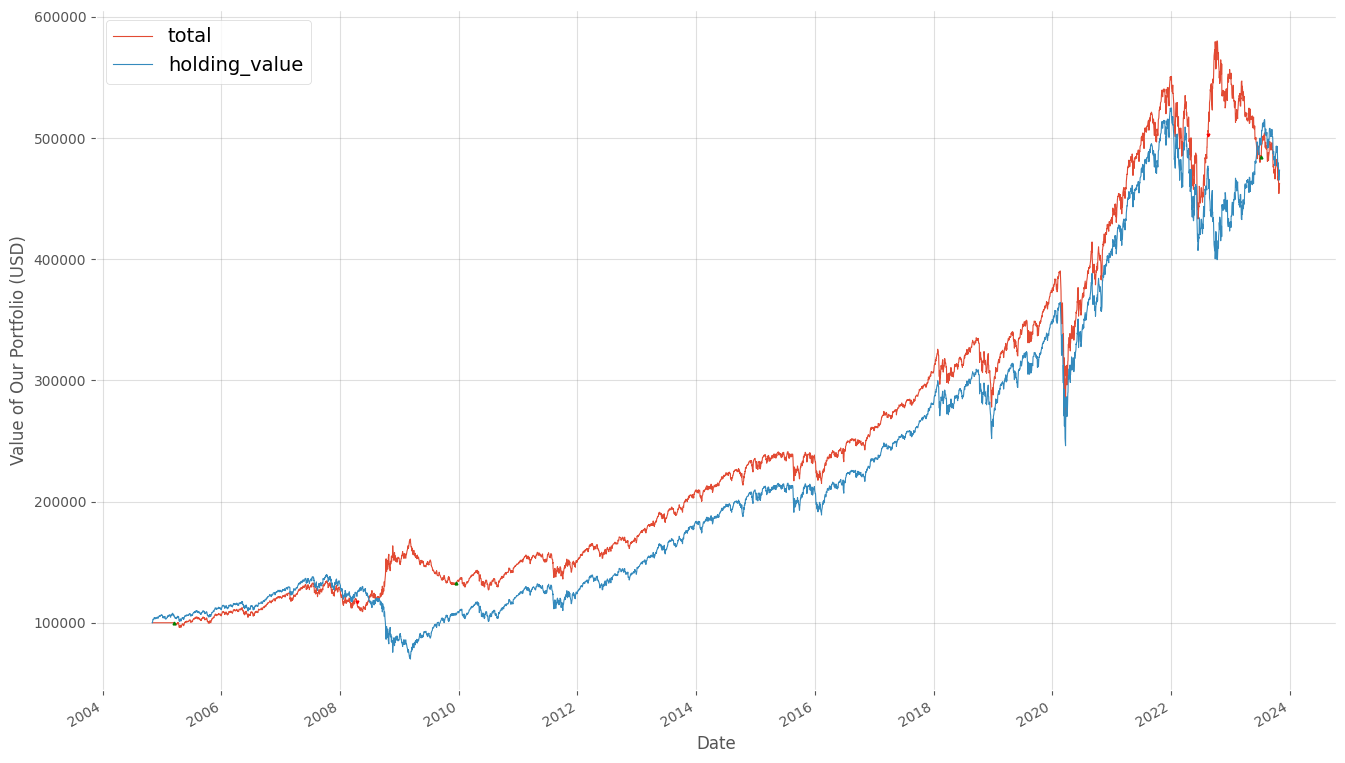

In [31]:
strategy_2_backtesting = Backtesting(snp,1100)

In [32]:
strategy_2_backtesting[strategy_2_backtesting['our_cash']<0]

,number of stock holdings,difference in shares owned,holdings market value,our_holdings,commission,our_cash,total,holding_value,cash_log_returns,cash_cumulative_returns,holding_log_returns,holding_cumulative_returns
Date,,,,,,,,,,,,


Hence, checked that at any point of time cash remaining is > 0. no money borrowing is involved

### Strategy 3 Backtesting

Strategy ending balance is: 177467.39959716797
S&P500 holding ending balance is: 439582.06939697266
Strategy cumulative return is: 77.46739959716807%
S&P500 holding cumulative return is: 339.58206939697266%


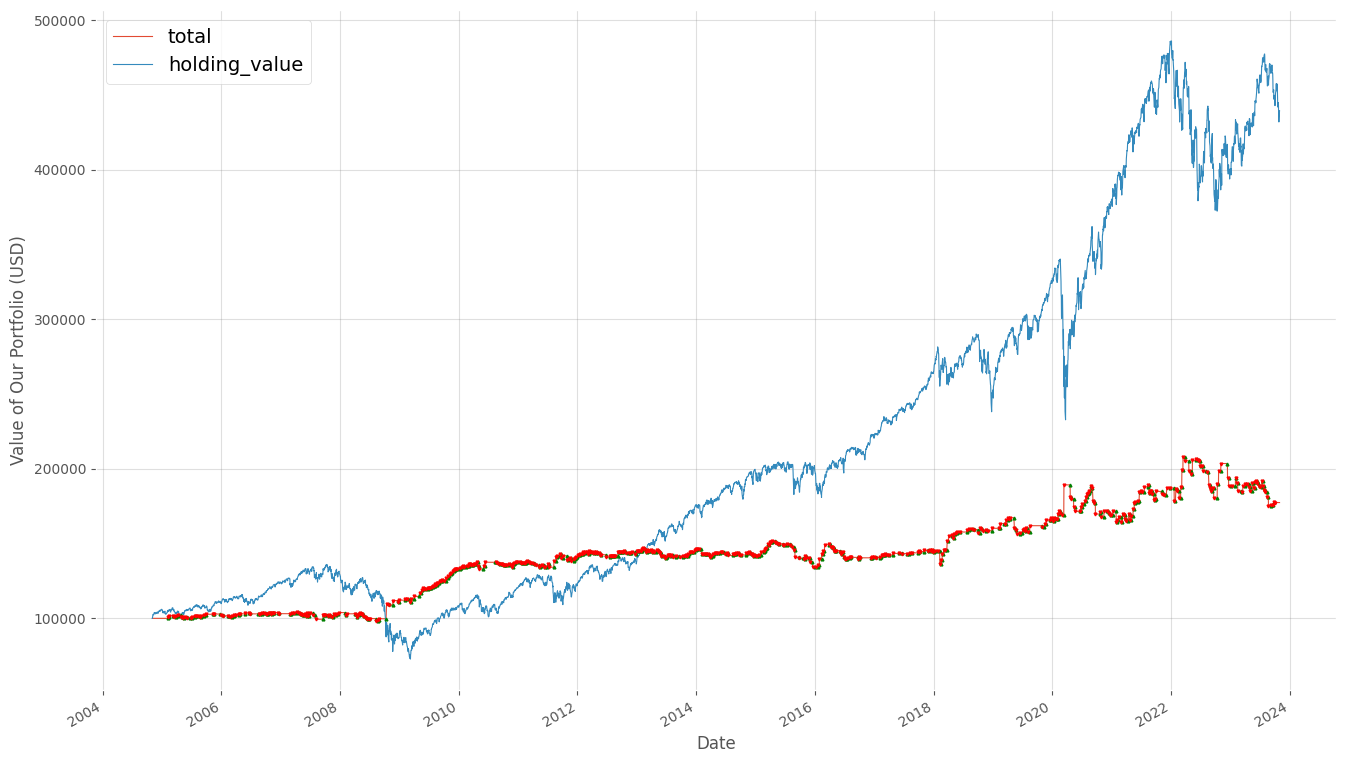

In [38]:
strategy_3_backtesting = Backtesting(spy_data,1000)

## 2. Sharpe

In [39]:
def Sharpe(stock_data, total_cash_column):
    
    stock_data["returns"] = stock_data[total_cash_column].pct_change()
    Sharpe = np.sqrt(253) * (stock_data["returns"].mean() / stock_data["returns"].std())
    
    return Sharpe


### Sharpe S&P500 Benchmark

In [40]:
Sharpe(strategy_1_backtesting, "holding_value")

0.5590162790382751

### Strategy 1 Sharpe

In [41]:
Sharpe(strategy_1_backtesting, "total")

0.5984853246389837

### Strategy 2 Sharpe

In [42]:
Sharpe(strategy_2_backtesting, "total")

0.6238156103566475

### Strategy 3 Sharpe

In [44]:
Sharpe(strategy_3_backtesting, "total")

0.4168489296735337

## 3. CAGR

In [45]:
def CAGR(stock_data, total_cash_column):
    stock_data = stock_data.dropna()
    days = (stock_data.index[-1] - stock_data.index[0]).days
    CAGR = (((stock_data[total_cash_column][-1])/(stock_data[total_cash_column][0]))**(365.0/days))-1
    return CAGR


### S&P500 Benchmark CAGR

In [46]:
CAGR(strategy_1_backtesting,"holding_value")

0.07824904872002758

### Strategy 1 CAGR

In [47]:
CAGR(strategy_1_backtesting,"total")

0.0865537643530443

### Strategy 2 CAGR

In [48]:
CAGR(strategy_2_backtesting,"total")

0.0839358284467766

### Strategy 3 CAGR

In [50]:
CAGR(strategy_3_backtesting,"total")

0.030646218516499513

## 4. MDD

In [51]:
def MDD(stock_data, cumulative_return_column_name):
    stock_data['max_gross_performance'] = stock_data[cumulative_return_column_name].cummax()
    stock_data['drawdown'] = (-stock_data['max_gross_performance'] + stock_data[cumulative_return_column_name])/stock_data['max_gross_performance']
    stock_data['drawdown_abs'] = -stock_data['max_gross_performance'] + stock_data[cumulative_return_column_name]

    max_drawdown = stock_data['drawdown'].min()
    abs_max_drawdown = stock_data['drawdown_abs'].min()

    print("max drawdown absolute is "+ str(abs_max_drawdown))
    print("max drawdown percentage is " +str(max_drawdown) + '%')

    # identify the points where new maximums are found
    breakeven_pts = stock_data['drawdown'].loc[stock_data['drawdown']==0].index

    # determine if the latest points where breakeven occurs
    if (stock_data[cumulative_return_column_name].iloc[-1] < stock_data['max_gross_performance'][-1]):
        breakeven_pts = breakeven_pts.append(stock_data.tail(1).index)
        print("the latest return is still in drawdown")

    # calculate the drawdown periods
    drawdown_periods = breakeven_pts[1:].to_pydatetime() - breakeven_pts[:-1].to_pydatetime()

    # to get the longest drawdown
    max_drawdown_period = drawdown_periods.max()
    
    stock_data[[cumulative_return_column_name, 'max_gross_performance']].plot(figsize = [16,6])

    # create a list to contain all dictionaries of each DD
    drawdowns = []

    for i in range(drawdown_periods.shape[0]):
        start = breakeven_pts[i] # start of the ith DD
        end = breakeven_pts[i+1] # end of the ith DD

        # calculate max DD of a given period
        max_drawdown = stock_data['drawdown'].loc[start:end].min()

        drawdowns.append({'start_date': start, 
                         'end_date': end, 
                         'drawdown_period':drawdown_periods[i], 
                         'max_drawdown': max_drawdown})
    drawdowns = pd.DataFrame(drawdowns).sort_values(by ='max_drawdown',ascending = True).reset_index(drop = True)
    print(drawdowns)

### S&P500 Benchmark MDD

max drawdown absolute is -1.0819502105712875
max drawdown percentage is -0.44783794492739337%
the latest return is still in drawdown
    start_date   end_date drawdown_period  max_drawdown
0   2007-10-09 2012-08-16       1773 days     -0.447838
1   2020-02-19 2020-08-10        173 days     -0.311180
2   2022-01-03 2023-10-31        666 days     -0.231686
3   2018-09-20 2019-04-12        204 days     -0.176042
4   2015-07-20 2016-04-18        273 days     -0.113704
..         ...        ...             ...           ...
544 2014-06-18 2014-06-19          1 days      0.000000
545 2014-06-09 2014-06-10          1 days      0.000000
546 2014-06-06 2014-06-09          3 days      0.000000
547 2014-08-25 2014-08-26          1 days      0.000000
548 2016-04-18 2016-04-19          1 days      0.000000

[549 rows x 4 columns]


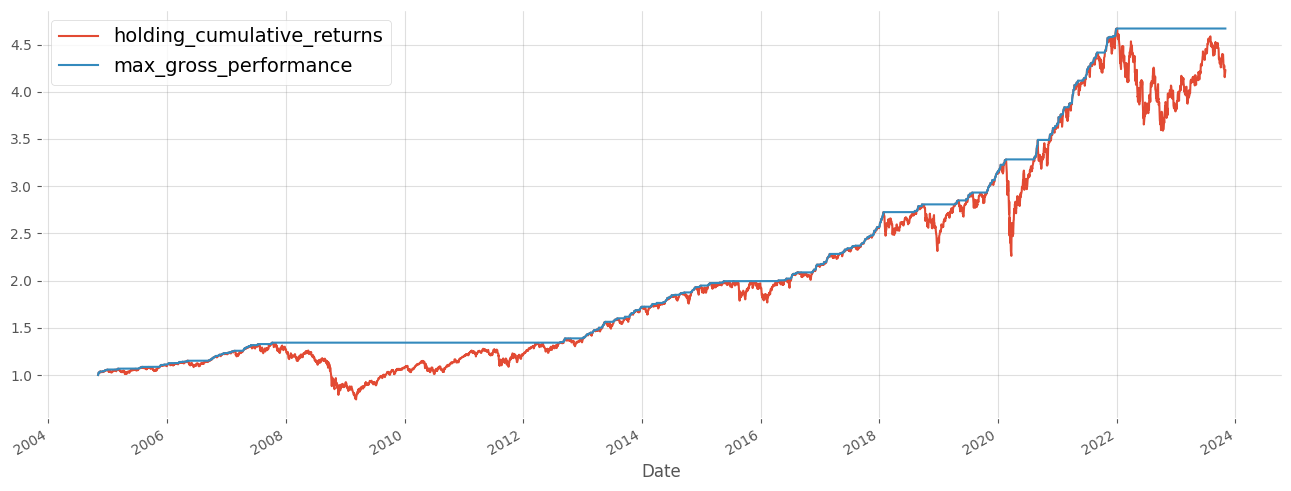

In [52]:
MDD(strategy_1_backtesting,'holding_cumulative_returns')

### Strategy 1 MDD

max drawdown absolute is -0.9583707733154361
max drawdown percentage is -0.49117156388162214%
the latest return is still in drawdown
    start_date   end_date drawdown_period  max_drawdown
0   2007-06-04 2013-01-23       2060 days     -0.491172
1   2020-01-23 2020-08-24        214 days     -0.288927
2   2022-01-03 2023-06-15        528 days     -0.158903
3   2018-12-03 2019-02-22         81 days     -0.136112
4   2015-06-23 2015-11-20        150 days     -0.088225
..         ...        ...             ...           ...
567 2015-02-04 2015-02-05          1 days      0.000000
568 2015-02-03 2015-02-04          1 days      0.000000
569 2005-07-06 2005-07-07          1 days      0.000000
570 2015-01-22 2015-01-23          1 days      0.000000
571 2004-11-03 2004-11-04          1 days      0.000000

[572 rows x 4 columns]


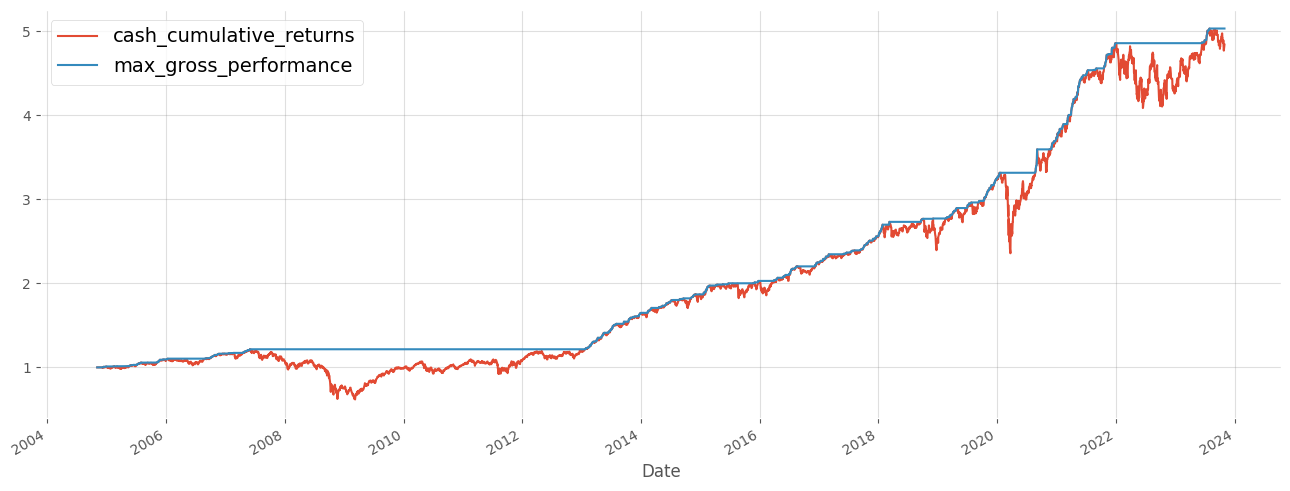

In [53]:
MDD(strategy_1_backtesting,'cash_cumulative_returns')

### Strategy 2 MDD

max drawdown absolute is -1.2596688537597682
max drawdown percentage is -0.30305294386758325%
the latest return is still in drawdown
    start_date   end_date drawdown_period  max_drawdown
0   2020-02-19 2020-08-10        173 days     -0.303053
1   2009-03-09 2012-09-13       1284 days     -0.248583
2   2022-10-12 2023-10-31        384 days     -0.217091
3   2022-01-03 2022-09-21        261 days     -0.213600
4   2007-10-09 2008-10-03        360 days     -0.188774
..         ...        ...             ...           ...
645 2013-01-17 2013-01-18          1 days      0.000000
646 2012-09-13 2012-09-14          1 days      0.000000
647 2009-03-02 2009-03-03          1 days      0.000000
648 2013-03-26 2013-03-27          1 days      0.000000
649 2014-08-20 2014-08-21          1 days      0.000000

[650 rows x 4 columns]


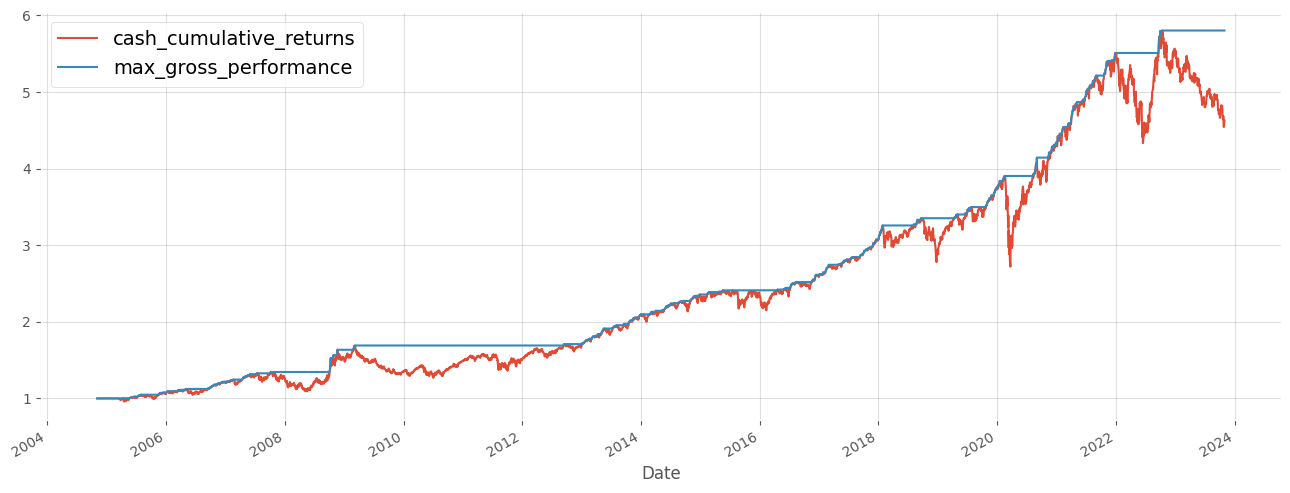

In [54]:
MDD(strategy_2_backtesting,'cash_cumulative_returns')

we had sold out just before the financial crisis, so there was no money made during this time. Turns out, strategy I tested was long only, i don't know how to short it at this point to make more. 

### Strategy 3 MDD

max drawdown absolute is -0.3324862670898432
max drawdown percentage is -0.15973520244368258%
the latest return is still in drawdown
    start_date   end_date drawdown_period  max_drawdown
0   2022-03-29 2023-10-31        581 days     -0.159735
1   2020-04-20 2022-03-09        688 days     -0.132301
2   2015-04-28 2018-03-26       1063 days     -0.113587
3   2019-05-10 2020-02-05        271 days     -0.065345
4   2007-04-20 2008-10-13        542 days     -0.054424
..         ...        ...             ...           ...
807 2009-02-02 2009-02-03          1 days      0.000000
808 2009-02-03 2009-02-04          1 days      0.000000
809 2009-02-04 2009-02-05          1 days      0.000000
810 2009-01-21 2009-01-22          1 days      0.000000
811 2009-12-02 2009-12-03          1 days      0.000000

[812 rows x 4 columns]


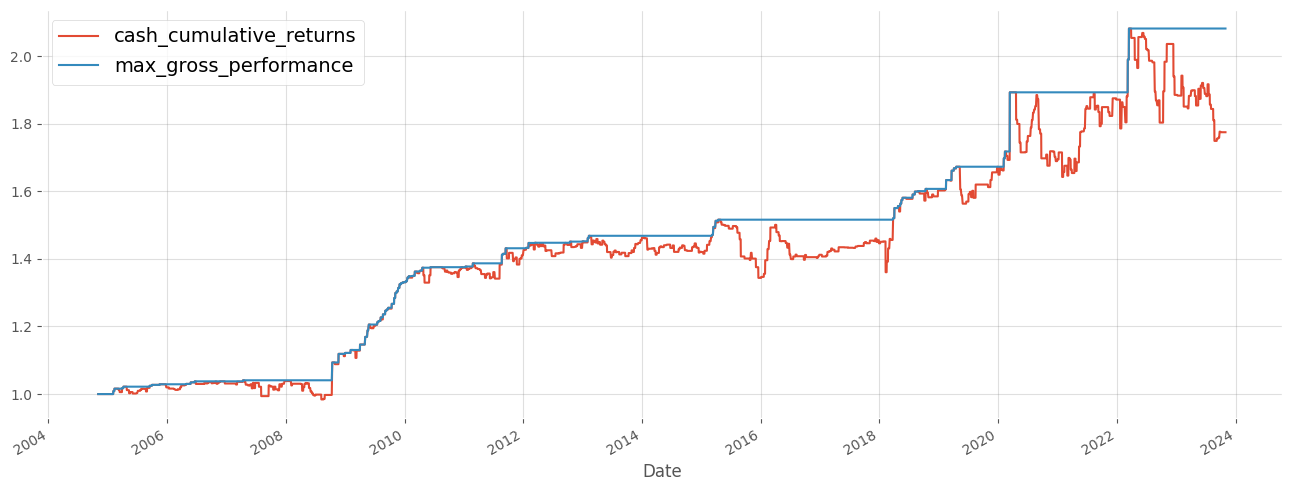

In [58]:
MDD(strategy_3_backtesting,'cash_cumulative_returns')